# Fast Pattern Matching
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/TDAmeritrade/stumpy/main?filepath=notebooks/Tutorial_Pattern_Searching.ipynb)

## Beyond Matrix Profiles

At the core of STUMPY, one can take any time series data and efficiently compute something called a [matrix profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html), which essentially scans along your entire times series with a fixed window size, `m`, and finds the exact nearest neighbor for every subsequence within your time series. A matrix profile allows you to determine if there are any conserved behaviors (i.e., conserved subsequences/patterns) within your data and, if so, it can tell you exactly where they are located within your time series. In a [previous tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html), we demonstrated how to use STUMPY to easily obtain a matrix profile, learned how to interpret the results, and discover meaningful motifs and discords. While this brute-force approach may be very useful when you don't know what pattern or conserved behavior you are looking but, for sufficiently large datasets, it can become quite expensive to perform this exhaustive pairwise search. 

However, if you already have a specific user defined pattern in mind then you don't actually need to compute the full matrix profile! For example, maybe you've identified an interesting trading strategy based on historical stock market data and you'd like to see if that specific pattern may have been observed in the past within one or more stock ticker symbols. In that case, searching for a known pattern or "query" is actually quite straightforward and can be accomplished quickly by using the wonderful `stumpy.mass` function in STUMPY.

In this short tutorial, we'll take a simple known pattern of interest (i.e., a query subsequence) and we'll search for this pattern in a separate independent time series. Let's get started!

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('stumpy.mplstyle')

## Loading the Sony AIBO Robot Dog Dataset

The time series data (below), `T_df`, has `n = 13000`  data points and it was collected from an accelerometer inside of a [Sony AIBO robot dog](https://en.wikipedia.org/wiki/AIBO) where it tracked the robot dog when it was walking from a cement surface onto a carpeted surface and, finally, back to the cement surface:

In [2]:
T_df = pd.read_csv("https://zenodo.org/record/4276393/files/Fast_Pattern_Searching_robot_dog.csv?download=1")
T_df.head()

,Acceleration
0,0.89969
1,0.89969
2,0.89969
3,0.89969
4,0.89969


## Visualizing the Sony AIBO Robot Dog Dataset

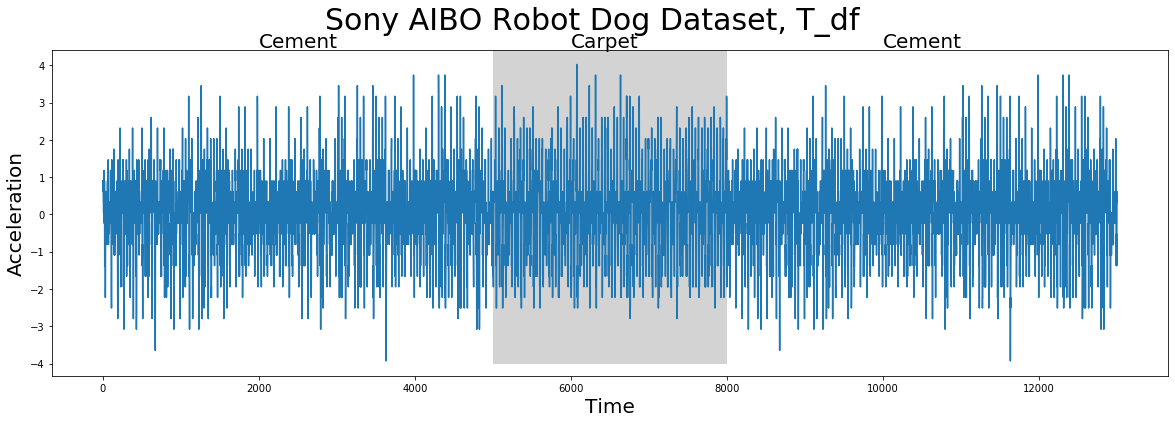

In [3]:
plt.suptitle('Sony AIBO Robot Dog Dataset, T_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(T_df)
plt.text(2000, 4.5, 'Cement', color="black", fontsize=20)
plt.text(10000, 4.5, 'Cement', color="black", fontsize=20)
ax = plt.gca()
rect = Rectangle((5000, -4), 3000, 10, facecolor='lightgrey')
ax.add_patch(rect)
plt.text(6000, 4.5, 'Carpet', color="black", fontsize=20)
plt.show()

In the plot above, the periods of time when the robot dog was walking on cement is displayed with a white background while the times when the robot dog was walking on carpet is highlighted with a grey background. Do you notice any appreciable difference(s) between walking on the different surfaces? Are there any interesting insights that you can observe with the human eye? Do any conserved patterns exist within this time series and, if so, where are they?

## Have You Seen This Pattern?

The subsequence pattern or query (below) that we are interested in searching for in the time series (above) looks like this:

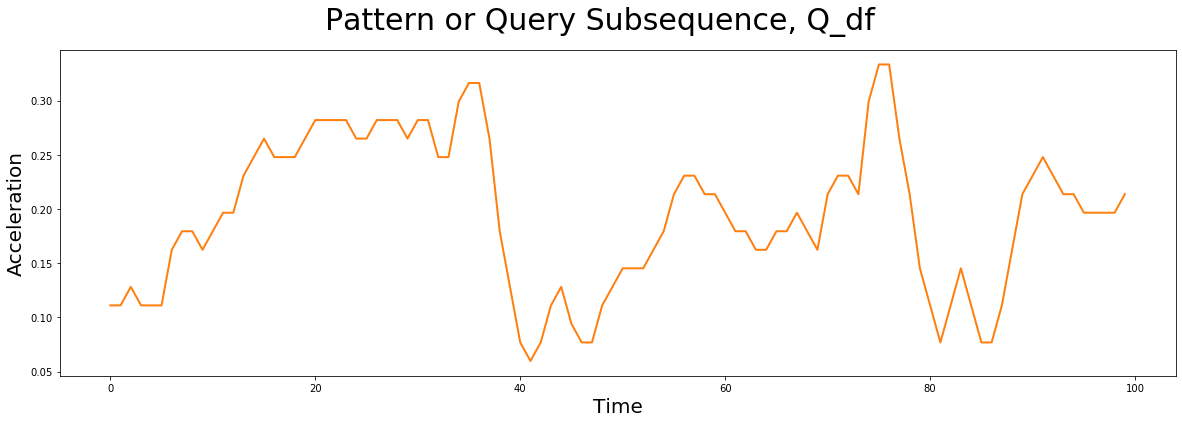

In [4]:
Q_df = pd.read_csv("https://zenodo.org/record/4276880/files/carpet_query.csv?download=1")

plt.suptitle('Pattern or Query Subsequence, Q_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(Q_df, lw=2, color="C1")  # Walking on cement
plt.show()

This pattern, `Q_df`, has a window length of `m = 100` and it was taken from a completely independent walking sample. Does it look familiar at all? Does a similar pattern exist in our earlier time series, `T_df`? Can you tell which surface the robot dog was walking on when this query sample was collected?

To answer some of these questions, you can compare this specific query subsequence or pattern with the full time series by computing something called a "distance profile". Essentially, you take this single query, `Q_df`, and compare it to every single subsequence in `T_df` by computing all possible (z-normalized Euclidean) pairwise distances. So, the distance profile is simply a 1-dimensional vector that tells you exactly how similar/dissimilar `Q_df` is to every subsequence (of the same length) found in `T_df`. Now, a naive algorithm for computing the distance profile would take `O(n*m)` time to process but, luckily, we can do much better than this as there exists a super efficient approach called ["Mueen's Algorithm for Similarity Search"](https://www.cs.unm.edu/~mueen/FastestSimilaritySearch.html) (MASS) that is able to compute the distance profile in much faster `O(n*log(n))` time (`log` base 2). Now, this may not be a big deal if you only have a few short time series to analyze but if you need to repeat this process many times with different query subsequences then things can add up quickly. In fact, as the length of the time series, `n`, and/or the length of the query subsequence, `m`, gets much longer, the naive algorithm would take way too much time!  

## Computing the Distance Profile with MASS

So, given a query subsequence, `Q_df`, and a time series, `T_df`, we can perform a fast similarity search and compute a distance profile using the `stumpy.mass` function in STUMPY:

In [5]:
distance_profile = stumpy.mass(Q_df["Acceleration"], T_df["Acceleration"])

And, since the `distance_profile` contains the full list of pairwise distances between `Q_df` and every subsequence within `T_df`, we can retrieve the most similar subsequence from `T_df` by finding the smallest distance value in `distance_profile` and extracting its positional index:

In [6]:
idx = np.argmin(distance_profile)

print(f"The nearest neighbor to `Q_df` is located at index {idx} in `T_df`")

The nearest neighbor to `Q_df` is located at index 7479 in `T_df`


So, to answer our earlier question of "Does a similar pattern exist in our earlier time series, T_df?", let's go ahead and plot the most similar subsequence in `T_df`, which is located at index 7479 (blue), and overlay this with our query pattern, `Q_df`, (orange):

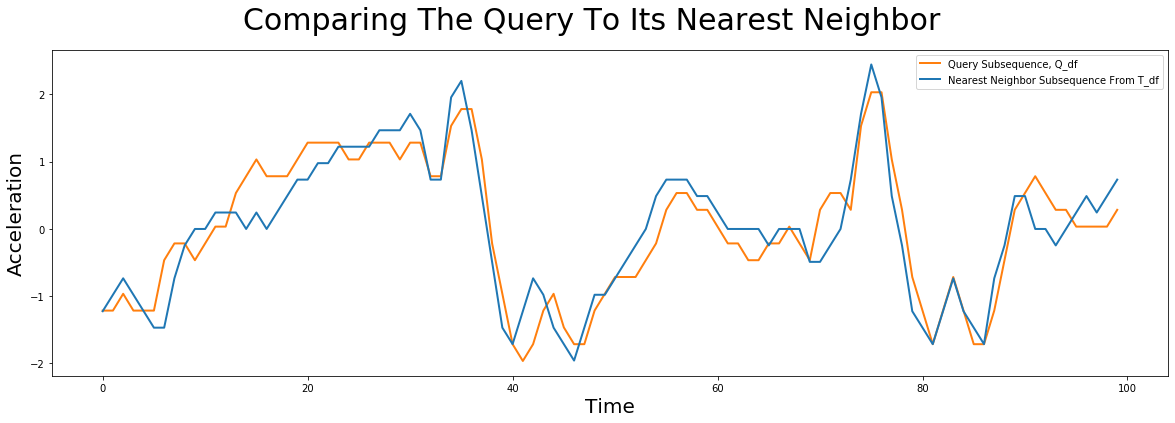

In [7]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
Q_z_norm = stumpy.core.z_norm(Q_df.values)
T_z_norm = stumpy.core.z_norm(T_df.values[idx:idx+len(Q_df)])

plt.suptitle('Comparing The Query To Its Nearest Neighbor', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(Q_z_norm, lw=2, color="C1", label="Query Subsequence, Q_df")
plt.plot(T_z_norm, lw=2, label="Nearest Neighbor Subsequence From T_df")
plt.legend()
plt.show()

Notice that even though the query subsequence does not perfectly match its nearest neighbor, STUMPY was still able to find it! And then, to answer the second question of "Can you tell which surface the robot dog was walking on when this query sample was collected?", we can look at precisely where `idx` is located within `T_df`:

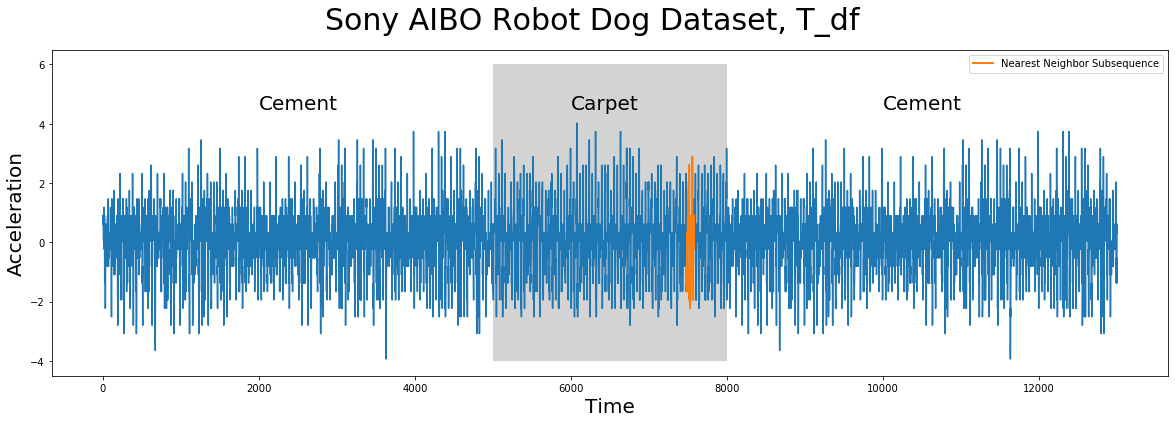

In [8]:
plt.suptitle('Sony AIBO Robot Dog Dataset, T_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(T_df)
plt.text(2000, 4.5, 'Cement', color="black", fontsize=20)
plt.text(10000, 4.5, 'Cement', color="black", fontsize=20)
ax = plt.gca()
rect = Rectangle((5000, -4), 3000, 10, facecolor='lightgrey')
ax.add_patch(rect)
plt.text(6000, 4.5, 'Carpet', color="black", fontsize=20)
plt.plot(range(idx, idx+len(Q_df)), T_df.values[idx:idx+len(Q_df)], lw=2, label="Nearest Neighbor Subsequence")
plt.legend()
plt.show()

As we can see above, the nearest neighbor (orange) to `Q_df` is a subsequence that is found when the robot dog was walking on carpet and, as it turns out, the `Q_df` was collected from an independent sample where the robot dog was walking on carpet too! To take this a step further, instead of extracting the only top nearest neighbor, we can look at where the top `k = 16` nearest neighbors are located:

In [9]:
# This simply returns the (sorted) positional indices of the top 16 smallest distances found in the distance_profile
k = 16
idxs = np.argpartition(distance_profile, k)[:k]
idxs = idxs[np.argsort(distance_profile[idxs])]

And then let's plot all of these subsequences based on their index locations:

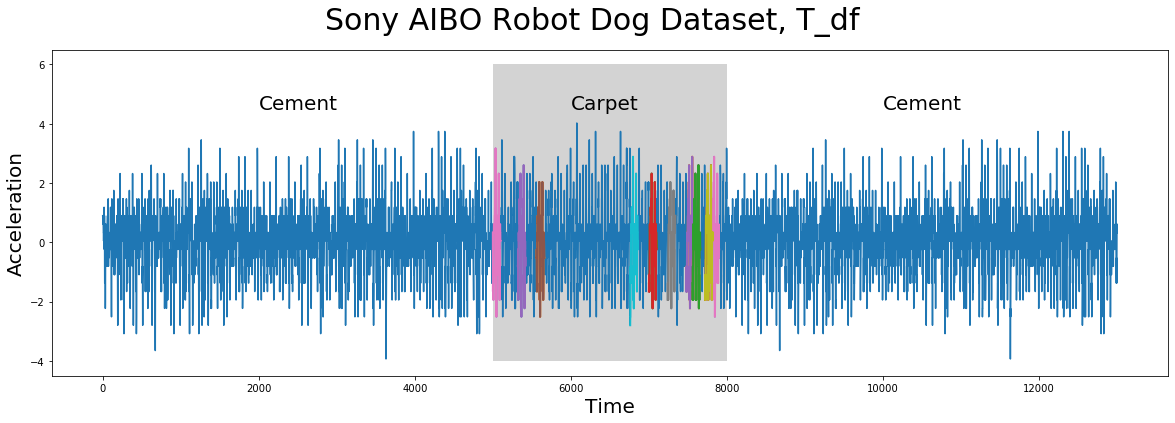

In [10]:
plt.suptitle('Sony AIBO Robot Dog Dataset, T_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(T_df)
plt.text(2000, 4.5, 'Cement', color="black", fontsize=20)
plt.text(10000, 4.5, 'Cement', color="black", fontsize=20)
ax = plt.gca()
rect = Rectangle((5000, -4), 3000, 10, facecolor='lightgrey')
ax.add_patch(rect)
plt.text(6000, 4.5, 'Carpet', color="black", fontsize=20)

for idx in idxs:
    plt.plot(range(idx, idx+len(Q_df)), T_df.values[idx:idx+len(Q_df)], lw=2)
plt.show()

Unsurprisingly, the top `k = 16` nearest neighbors to `Q_df` (or best matches, shown in multiple colors above) can all be found when the robot dog was walking on the carpet (grey)!

## Levaraging STUMPY to do some work for you

Until now, you learned how to search for similar matches to your query using a raw distance profile. While this is feasible, STUMPY provides you with a super powerful function called `match` that does even more work for you. One benefit of using match is that, as it discovers each new neighbor, it applies an exclusion zone around it and this ensures that every match that is returned is actually a unique occurrence of your input query. In this section we will explore how to use it to produce the same results as above.

First, we will call `stumpy.match` only with the two requiered parameters, `Q`, your query, and `T`, the time series you want to look at.

In [11]:
matches = stumpy.match(Q_df["Acceleration"], T_df["Acceleration"])
matches

array([[3.95450328975567, 7479],
       [4.103417109633875, 6999],
       [4.331617654400913, 7719],
       [4.4628747408769565, 7559],
       [4.545081494715392, 7799],
       [4.589847040716157, 7239],
       [4.91235551278288, 6759],
       [4.937207748305622, 5239],
       [4.965215601965966, 5559],
       [5.138641700896022, 5319],
       [5.229425485675162, 4999],
       [5.317043268232974, 7079],
       [5.429005214640067, 5799],
       [5.524176144537862, 5479],
       [5.530467881664306, 5719],
       [5.619145004389995, 5959],
       [5.691399823068097, 7319],
       [5.744641520318367, 6439],
       [5.907615742172685, 5079],
       [5.996903058566823, 6519],
       [6.148218899624257, 6599],
       [6.213757508330553, 6839],
       [6.520091775437268, 6199],
       [6.710384909809467, 6359],
       [6.735874381071516, 6679],
       [6.863383301933689, 1707],
       [6.863383301933707, 9707],
       [6.865637543790573, 7599],
       [6.906699435313571, 3548],
       [6.90669

Match returns a 2D numpy array which contains all matches of `Q` in `T` sorted by distance. The first column represents the (z-normalized) distance of each match to `Q`, while the second column represents the starting index of the match in `T`. If we look at the very first row, we see that the best match of `Q` in `T` starts at position 7479 and has a z-normalized distance of 3.955. This corresponds exactly to the best match from before!

Now, you might wonder which subsequences of `T` count as matches of `Q`. Earlier, we manually sorted the distance profile in ascending order and defined the to 16 matches to be the 16 subsequences with the lowest distance. While we can emulate this behavior with `stumpy.match` (see the end of this section), the preferred way is to return all subsequences that are closer than some threshold. This threshold is controlled using the `max_distance` parameter. 

STUMPY tries to find a reasonable default value, however, in general this is very difficult, because it depends on your use case. For example, if you have EEG data of a patient's heartbeat and want to match one specific beat, then you may consider using a smaller threshold since your time series may be highly regular. On the other hand, if you try to match a specific word in a voice recording, you would probably need a larger threshold, as the exact shape of your match could be influenced by how one pronounces said word.

Let's plot all of the discovered matches to see if we need to adjust our threshold.

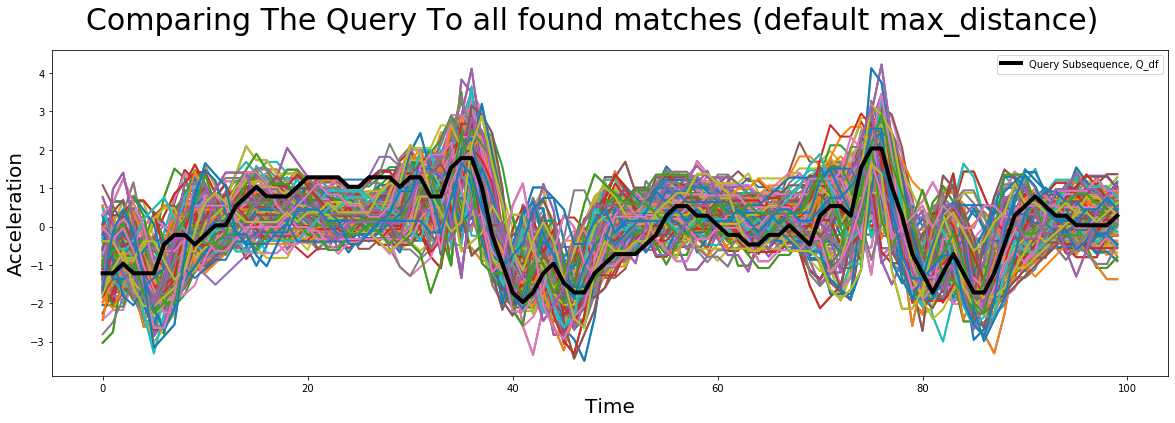

In [12]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
Q_z_norm = stumpy.core.z_norm(Q_df.values)

plt.suptitle('Comparing The Query To all found matches (default max_distance)', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
for match_distance, match_idx in matches:
    match_z_norm = stumpy.core.z_norm(T_df.values[match_idx:match_idx+len(Q_df)])
    plt.plot(match_z_norm, lw=2)
plt.plot(Q_z_norm, lw=4, color="black", label="Query Subsequence, Q_df")
plt.legend()
plt.show()

We see, that we do not see a lot. While some of the main feature are somewhat conserved across all subsequences, there seems to be a lot of artifacts as well.

With `stumpy.match`, you have two options for controlling the threshold. You can either specify a constant value (e.g., max_distance=5.0) or provide a custom function. This function has to take one parameter, which will be the distance profile, D, between Q and T. This way, you can encode some dependency on the distance profile into your maximum distance threshold. The default maximum distance is `max_distance = max(np.mean(D) - 2 * np.std(D), np.min(D))`. This is the typical "two standard deviations below from the mean". 

Typically, one has to experiment a bit with what an acceptable maximum distance so let's try to change it to "four standard deviations below the mean" (i.e., a smaller maximum distance).

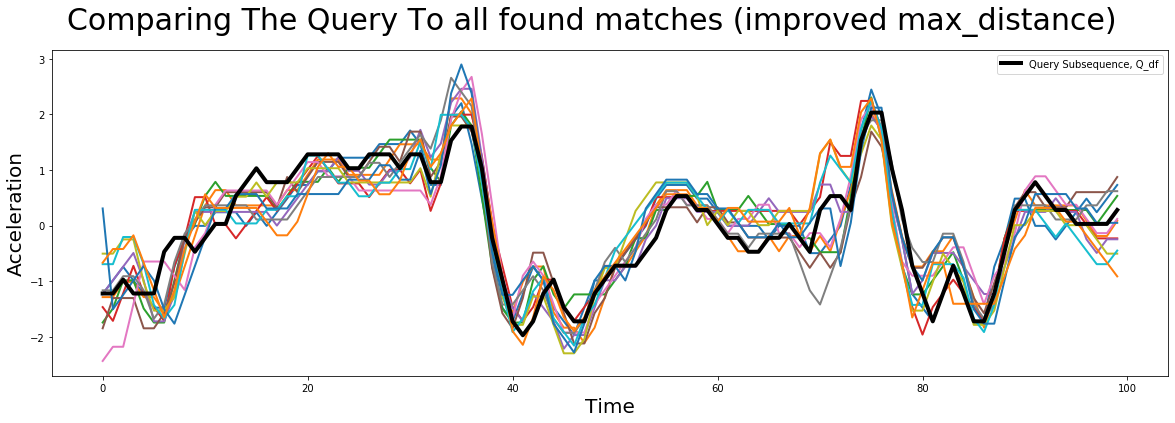

In [13]:
matches_improved_max_distance = stumpy.match(
    Q_df["Acceleration"], 
    T_df["Acceleration"],
    max_distance=lambda D: max(np.mean(D) - 4 * np.std(D), np.min(D))
)

# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
Q_z_norm = stumpy.core.z_norm(Q_df.values)

plt.suptitle('Comparing The Query To all found matches (improved max_distance)', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
for match_distance, match_idx in matches_improved_max_distance:
    match_z_norm = stumpy.core.z_norm(T_df.values[match_idx:match_idx+len(Q_df)])
    plt.plot(match_z_norm, lw=2)
plt.plot(Q_z_norm, lw=4, color="black", label="Query Subsequence, Q_df")
plt.legend()
plt.show()

We see, that this looks much more promising and we did indeed find very similar looking matches. Sometimes, one still is not interested in all matches in the specified region. The easiest way to adjust this, is to set `max_matches` to the maximum number of matches you want. By default, it is `None`, which means that all matches will be returned.

### Emulating finding to top-k matches

Sometimes, for example if you have not yet decided what a good threshold would be, you still want to find the top-k matches. And sometimes, you want to deactivate the automatic exclusion zone, to also find matches that have a very close index in `T`. This can be done easily in the following way (for `k=16`):

In [14]:
m = Q_df["Acceleration"].size
int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))

25

In [15]:
STUMPY_EXCL_ZONE_DENOM_old = stumpy.config.STUMPY_EXCL_ZONE_DENOM
# To set the exclusion zone to zero, set the denominator to np.`inf`
stumpy.config.STUMPY_EXCL_ZONE_DENOM = np.inf

matches_top_16 = stumpy.match(
    Q_df["Acceleration"], 
    T_df["Acceleration"],
    max_distance=np.inf, # set the threshold to infinity include all subsequences
    max_matches=16,      # find the top 16 matches
)

stumpy.config.STUMPY_EXCL_ZONE_DENOM = STUMPY_EXCL_ZONE_DENOM_old # Reset the denominator to its default value

To show that this does the same as we did in the first part of the tutorial, we will assert that the newly found indices are equal to the indices we found above using the `stumpy.mass` method.

In [16]:
npt.assert_equal(matches_top_16[:,1], idxs)

No error, this means they are indeed equal!

Typically, one has to experiment a bit with what an acceptable maximum distance so let's try to change it to "four standard deviations below the mean" (i.e., a smaller maximum distance).

## Summary

And that's it! You have now taken a known pattern of interest (or query), ran it through `stumpy.mass` using STUMPY, and you were able to quickly search for this pattern in another time series. Moreover, you learned how to use the `stumpy.match` function, to let stumpy handle a lot of the work for you. With this newfound knowledge, you can now go and search for patterns in your own time series projects. Happy coding!

## Additional Note - Distance Profiles with Non-normalized Euclidean Distances

There are times when you may want to use non-normalized Euclidean distance as your measure of similarity/dissimilarity, and so, instead of using `stumpy.mass` (which z-normalizes your subsequences first before computing the pairwise Euclidean distances), you can use the `core.mass_absolute` function. This is provided for those who are interested in computing the non-normalized matrix profiles that are available in the complementary `stumpy.aamp`, `stumpy.aamped`, `stumpy.gpu_aamp`, and `stumpy.ammpi` functions. If you are using `stumpy.match`, you only need to pass the `normalize=False` keyword.

## Bonus Section - What Makes MASS So Fast?

The reason why MASS is so much faster than a naive approach is because MASS uses Fast Fourier Transforms (FFT) to convert the data into the frequency domain and performs what is called a "convolution", which reduces the `m` operations down to `log(n)` operations. You can read more about this in the original [Matrix Profile I paper](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf). 

Here's a naive implementation of computing a distance profile:

In [17]:
import time

def compute_naive_distance_profile(Q, T):
    Q = Q.copy()
    T = T.copy()
    n = len(T)
    m = len(Q)
    naive_distance_profile = np.empty(n - m + 1)

    start = time.time()
    Q = stumpy.core.z_norm(Q)
    for i in range(n - m + 1):
        naive_distance_profile[i] = np.linalg.norm(Q - stumpy.core.z_norm(T[i:i+m]))
    naive_elapsed_time = time.time()-start
    
    print(f"For n = {n} and m = {m}, the naive algorithm takes {np.round(naive_elapsed_time, 2)}s to compute the distance profile")

    return naive_distance_profile

For a random time series, `T_random`, with 1 million data points and a random query subsequence, `Q_random`:

In [18]:
Q_random = np.random.rand(100)
T_random = np.random.rand(1_000_000)

naive_distance_profile = compute_naive_distance_profile(Q_random, T_random)

For n = 1000000 and m = 100, the naive algorithm takes 44.75s to compute the distance profile


The naive algorithm takes over half a minute to compute! However, MASS can handle this (and even larger data sets) in about a 1 second:

In [19]:
start = time.time()
mass_distance_profile = stumpy.mass(Q_random, T_random)
mass_elapsed_time = time.time()-start

print(f"For n = {len(T_random)} and m = {len(Q_random)}, the MASS algorithm takes {np.round(mass_elapsed_time, 2)}s to compute the distance profile")

For n = 1000000 and m = 100, the MASS algorithm takes 0.11s to compute the distance profile


And to be absolutely certain, let's make sure and check that the output is the same from both methods:

In [20]:
npt.assert_almost_equal(naive_distance_profile, mass_distance_profile)

Success, no errors! This means that both outputs are identical. Go ahead and give it a try! 

## Resources

[The Fastest Similarity Search Algorithm for Time Series Subsequences Under Euclidean Distance](http://www.cs.unm.edu/~mueen/FastestSimilaritySearch.html)


[STUMPY Documentation](https://stumpy.readthedocs.io/en/latest/)

[STUMPY Matrix Profile Github Code Repository](https://github.com/TDAmeritrade/stumpy)